In [190]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [191]:
import pandas as pd
pd.options.display.max_columns = 1000
pd.options.display.max_rows = 10000
import matplotlib.pyplot as plt
import datetime
import numpy as np

## Join data from all coins

In [192]:
coins = ['BTC','ETH']#,'LTC','BCH','XRP']
not_coins = []#['BTC']

all_coins = pd.DataFrame()
for coin in coins:
    data = pd.read_csv(r'C:\Users\Jameshuckle\Dropbox\Bitcoin\SimpleDigitalAssets\\'+coin+'-USD-CMC.csv',thousands=',')
    data = data[['Date','Close','Market Cap']]
    data.columns = ['date',coin,coin+'_mc']
    if len(all_coins) == 0:
        all_coins = data
    else:
        all_coins = all_coins.merge(data,on='date',how='outer')

In [193]:
coins_mc = [coin+'_mc' for coin in coins if coin not in not_coins]

## Calc market cap weight for each coin

In [194]:

all_coins['total_market_cap'] = all_coins[coins_mc].sum(axis='columns')
for coin in coins:
    print(coin)
    if coin in not_coins:
        all_coins[coin+'_wt'] = np.nan
        continue
    all_coins[coin+'_wt'] = (all_coins[coin+'_mc']/all_coins['total_market_cap']).round(2)

BTC
ETH


In [195]:
coins_wt = [coin+'_wt' for coin in coins]

## Reverse order to ascending

In [196]:
all_coins['date'] = pd.to_datetime(all_coins['date'])
all_coins = all_coins.sort_values('date')

## Filter for rebalance frequency

In [200]:
frequency = 'daily' #'weekly','daily','monthly'

if frequency == 'daily':
    rebalance_freq = all_coins.copy() # daily
    sharpe_divisor = 252
elif frequency == 'weekly':
    rebalance_freq = all_coins[all_coins['date'].dt.day.isin([1,7,14,21,28])].copy() # weekly
    sharpe_divisor = 52
elif frequency == 'monthly':
    rebalance_freq = all_coins[all_coins['date'].dt.day.isin([1])].copy() # monthly
    sharpe_divisor = 12

## time period
#rebalance_freq = rebalance_freq[rebalance_freq['date']>datetime.datetime(2017,1,1)]

for coin in coins:
    coin_per = rebalance_freq[coin].pct_change() + 1
    rebalance_freq[coin+'%'] = coin_per
    rebalance_freq[coin+'_result'] = coin_per * rebalance_freq[coin+'_wt'].shift(1)
    
coins_res = [coin+'_result' for coin in coins]
rebalance_freq['tot_result'] = rebalance_freq[coins_res].sum(axis='columns')  
rebalance_freq.iloc[0,-1] = 1
rebalance_freq['product_no_fees'] = rebalance_freq['tot_result'].cumprod()

fees = 0.003
spread = 0 #0.001
slippage = 0 #0.0005
total_costs = (fees+spread+slippage)*2
rebalance_freq['fees'] = (rebalance_freq[coins_wt].diff().abs().sum(axis='columns')*total_costs)
#rebalance_freq['tot_gain'] = rebalance_freq[coins_per]
rebalance_freq['tot_result'] = rebalance_freq['tot_result']-rebalance_freq['fees']

rebalance_freq['product_after_fees'] = rebalance_freq['tot_result'].cumprod()
BTC_result = rebalance_freq['BTC%'].copy()
BTC_result.iloc[0] = 1
rebalance_freq['BTC_product'] = BTC_result.cumprod()


In [201]:
rebalance_freq['Daily_return_product'] = rebalance_freq['product_no_fees'].pct_change(1)
sharpe_ratio_portfolio = (sharpe_divisor **0.5) * rebalance_freq['Daily_return_product'].mean() / rebalance_freq['Daily_return_product'].std()
print('return on capital portfolio:',rebalance_freq['product_no_fees'].values[-1])
print('sharpe ratio portfolio:',sharpe_ratio_portfolio)
rebalance_freq['Daily_return_BTC'] = rebalance_freq['BTC_product'].pct_change(1)
sharpe_ratio_portfolio = (sharpe_divisor **0.5) * rebalance_freq['Daily_return_BTC'].mean() / rebalance_freq['Daily_return_BTC'].std()
print('return on capital BTC:',rebalance_freq['BTC_product'].values[-1])
print('sharpe ratio BTC:',sharpe_ratio_portfolio)
rebalance_freq

return on capital portfolio: 65.64383291108335
sharpe ratio portfolio: 1.0355145143979585
return on capital BTC: 59.513970643022105
sharpe ratio BTC: 1.0169469489140388


,date,BTC,BTC_mc,ETH,ETH_mc,total_market_cap,BTC_wt,ETH_wt,BTC%,BTC_result,ETH%,ETH_result,tot_result,product_no_fees,fees,product_after_fees,BTC_product,Daily_return_product,Daily_return_BTC
2217,2013-04-28,134.21,1488566728,NaN,NaN,1.488567e+09,1.00,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,0.00000,1.000000,1.000000,NaN,NaN
2216,2013-04-29,144.54,1603768865,NaN,NaN,1.603769e+09,1.00,NaN,1.076969,1.076969,NaN,NaN,1.076969,1.076969,0.00000,1.076969,1.076969,0.076969,0.076969
2215,2013-04-30,139.00,1542813125,NaN,NaN,1.542813e+09,1.00,NaN,0.961672,0.961672,NaN,NaN,0.961672,1.035690,0.00000,1.035690,1.035690,-0.038328,-0.038328
2214,2013-05-01,116.99,1298954594,NaN,NaN,1.298955e+09,1.00,NaN,0.841655,0.841655,NaN,NaN,0.841655,0.871694,0.00000,0.871694,0.871694,-0.158345,-0.158345
2213,2013-05-02,105.21,1168517495,NaN,NaN,1.168517e+09,1.00,NaN,0.899308,0.899308,NaN,NaN,0.899308,0.783921,0.00000,0.783921,0.783921,-0.100692,-0.100692
2212,2013-05-03,97.75,1085995169,NaN,NaN,1.085995e+09,1.00,NaN,0.929094,0.929094,NaN,NaN,0.929094,0.728336,0.00000,0.728336,0.728336,-0.070906,-0.070906
2211,2013-05-04,112.50,1250316563,NaN,NaN,1.250317e+09,1.00,NaN,1.150895,1.150895,NaN,NaN,1.150895,0.838239,0.00000,0.838239,0.838239,0.150895,0.150895
2210,2013-05-05,115.91,1288693176,NaN,NaN,1.288693e+09,1.00,NaN,1.030311,1.030311,NaN,NaN,1.030311,0.863647,0.00000,0.863647,0.863647,0.030311,0.030311
2209,2013-05-06,112.30,1249023060,NaN,NaN,1.249023e+09,1.00,NaN,0.968855,0.968855,NaN,NaN,0.968855,0.836748,0.00000,0.836748,0.836748,-0.031145,-0.031145
2208,2013-05-07,111.50,1240593600,NaN,NaN,1.240594e+09,1.00,NaN,0.992876,0.992876,NaN,NaN,0.992876,0.830788,0.00000,0.830788,0.830788,-0.007124,-0.007124


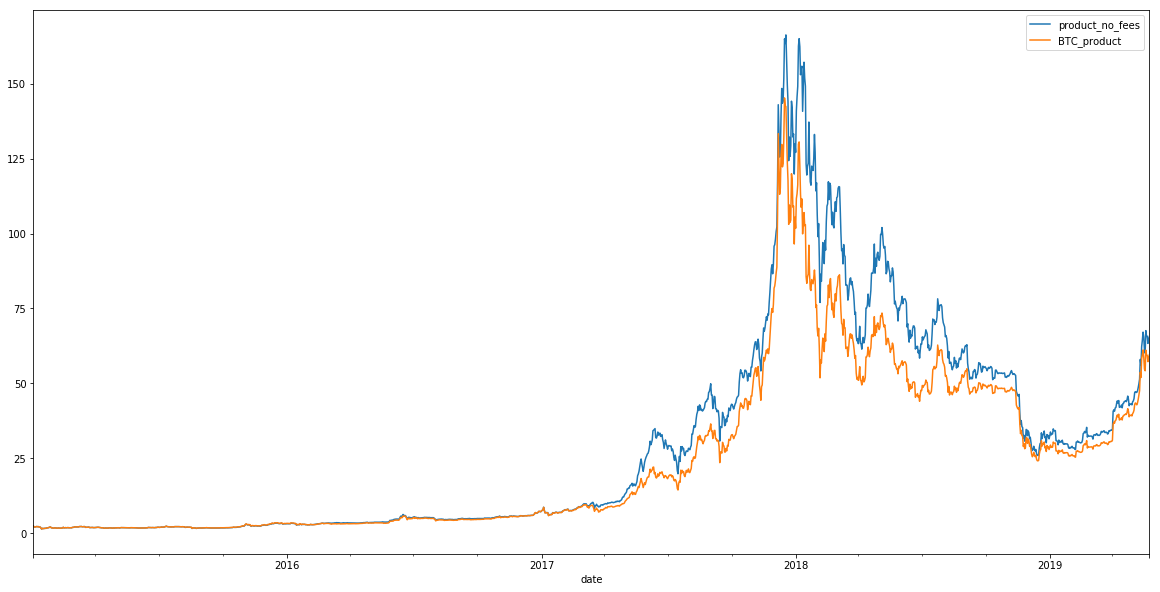

In [202]:
rebalance_freq = rebalance_freq[rebalance_freq['date']>datetime.datetime(2015,1,1)]
ax = rebalance_freq.plot(x='date',y='product_no_fees',figsize=(20,10))
rebalance_freq.plot(x='date',y='BTC_product',ax=ax)
#rebalance_freq.plot(x='date',y='product_after_fees',ax=ax)
plt.show()